## Programming Assignment (20 points)

In this assignment, you will solve an irony detection task: given a tweet, your job is to classify whether it is ironic or not.

You will implement a new classifier that does not rely on feature engineering as in previous homeworks. Instead, you will use pretrained word embeddings downloaded from using the `irony.py` script as your input feature vectors. Then, you will encode your sequence of word embeddings with an (already implemented) LSTM and classify based on its final hidden state.


In [1]:
# This is so that you don't have to restart the kernel everytime you edit hmm.py

%load_ext autoreload
%autoreload 2

## Data

We will use the dataset from SemEval-2018: https://github.com/Cyvhee/SemEval2018-Task3

In [2]:
from irony import load_datasets
from sklearn.model_selection import train_test_split

train_sentences, train_labels, test_sentences, test_labels, label2i = load_datasets()

# TODO: Split train into train/dev
train_sentences, dev_sentences, train_labels, dev_labels = train_test_split(train_sentences, train_labels, train_size=0.8)

## Baseline: Naive Bayes

We have provided the solution for the Naive Bayes part from HW2 in [bayes.py](bayes.py)

There are two implementations: NaiveBayesHW2 is what was expected from HW2. However, we will use a more effecient implementation of it that uses vector operations to calculate the probabilities. Please go through it if you would like to

In [3]:
from irony import run_nb_baseline

run_nb_baseline()

Vectorizing Text: 100%|██████████| 784/784 [00:00<00:00, 28879.74it/s]

Baseline: Naive Bayes Classifier
F1-score Ironic: 0.6402966625463535
Avg F1-score: 0.6284487265300938


### Task 1: Implement avg_f1_score() in [util.py](util.py). Then re-run the above cell  (2 Points)

So the micro F1-score for the test set of the Ironic Class using a Naive Bayes Classifier is **0.64**

## Logistic Regression with Word2Vec  (Total: 18 Points)

Unlike sentiment, Irony is very subjective, and there is no word list for ironic and non-ironic tweets. This makes hand-engineering features tedious, therefore, we will use word embeddings as input to the classifier, and make the model automatically extract features aka learn weights for the embeddings

## Tokenizer for Tweets


Tweets are very different from normal document text. They have emojis, hashtags and bunch of other special character. Therefore, we need to create a suitable tokenizer for this kind of text.

Additionally, as described in class, we also need to have a consistent input length of the text document in order for the neural networks built over it to work correctly.

### Task 2: Create a Tokenizer with Padding (5 Points)

Our Tokenizer class is meant for tokenizing and padding batches of inputs. This is done
before we encode text sequences as torch Tensors.

Update the following class by completing the todo statements.

In [4]:
from typing import Dict, List, Optional, Tuple
from collections import Counter

import torch
import numpy as np
import spacy


class Tokenizer:
    """Tokenizes and pads a batch of input sentences."""

    def __init__(self, pad_symbol: Optional[str] = "<PAD>"):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<PAD>".
        """
        self.pad_symbol = pad_symbol
        self.nlp = spacy.load("en_core_web_lg")
    
    def __call__(self, batch: List[str]) -> List[List[str]]:
        """Tokenizes each sentence in the batch, and pads them if necessary so
        that we have equal length sentences in the batch.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            List[List[str]]: A List of equal-length token Lists.
        """
        batch = self.tokenize(batch)
        batch = self.pad(batch)

        return batch

    def tokenize(self, sentences: List[str]) -> List[List[str]]:
        """Tokenizes the List of string sentences into a Lists of tokens using spacy tokenizer.

        Args:
            sentences (List[str]): The input sentence.

        Returns:
            List[str]: The tokenized version of the sentence.
        """
        tokenized_sents = []
        # TODO: Tokenize the input with spacy.
        for sent in sentences:
            sent_tokens = [token.text.lower() for token in self.nlp(sent)]
        # TODO: Make sure the start token is the special <SOS> token and the end token
        #       is the special <EOS> token
            sent_tokens = ['<SOS>'] + sent_tokens + ['<EOS>']
            tokenized_sents.append(sent_tokens)

        return tokenized_sents
        # raise NotImplementedError

    def pad(self, batch: List[List[str]]) -> List[List[str]]:
        """Appends pad symbols to each tokenized sentence in the batch such that
        every List of tokens is the same length. This means that the max length sentence
        will not be padded.

        Args:
            batch (List[List[str]]): Batch of tokenized sentences.

        Returns:
            List[List[str]]: Batch of padded tokenized sentences. 
        """
        # TODO: For each sentence in the batch, append the special <P>
        #       symbol to it n times to make all sentences equal length
        out_batch = []
        max_len = max([len(sent) for sent in batch])
        for sent in batch:
            out_batch.append(sent + [self.pad_symbol]*(max_len - len(sent)))
        return out_batch
        # raise NotImplementedError
        

In [5]:
# create the vocabulary of the dataset: use both training and test sets here

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>']

all_data = train_sentences + dev_sentences + test_sentences
my_tokenizer = Tokenizer()

tokenized_data = my_tokenizer.tokenize(all_data)
vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))

with open('vocab.txt', 'w') as vf:
    vf.write('\n'.join(vocab))

## Embeddings

We use GloVe embeddings https://nlp.stanford.edu/projects/glove/. But these do not necessarily have all of the tokens that will occur in tweets! Hoad the GloVe embeddings, pruning them to only those words in vocab.txt. This is to reduce the memory and runtime of your model.

Then, find the out-of-vocabulary words (oov) and add them to the encoding dictionary and the embeddings matrix.

In [6]:
# Dowload the gloVe vectors for Twitter tweets. This will download a file called glove.twitter.27B.zip
# ! wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [7]:
# unzip glove.twitter.27B.zip
# if there is an error, please download the zip file again

# ! unzip glove.twitter.27B.zip

In [8]:
# Let's see what files are there:

! ls . | grep "glove.*.txt"

In [9]:
# For this assignment, we will use glove.twitter.27B.50d.txt which has 50 dimensional word vectors
# Feel free to experiment with vectors of other sizes

embedding_path = '/Users/anupbhutada/Documents/Courses/Natural Langauge Processing/Assignment4/assignment_4/glove.twitter.27B.100d.txt'
vocab_path = "./vocab.txt"

## Creating a custom Embedding Layer

Now the GloVe file has vectors for about 1.2 million words. However, we only need the vectors for a very tiny fraction of words -> the unique words that are there in the classification corpus. Some of the next tasks will be to create a custom embedding layer that has the vectors for this small set of words

### Task 2: Extracting word vectors from GloVe (3 Points)

In [10]:
from typing import Dict, Tuple

import torch


def read_pretrained_embeddings(
    embeddings_path: str,
    vocab_path: str
) -> Tuple[Dict[str, int], torch.FloatTensor]:
    """Read the embeddings matrix and make a dict hashing each word.

    Note that we have provided the entire vocab for train and test, so that for practical purposes
    we can simply load those words in the vocab, rather than all 27B embeddings

    Args:
        embeddings_path (str): _description_
        vocab_path (str): _description_

    Returns:
        Tuple[Dict[str, int], torch.FloatTensor]: _description_
    """
    word2i = {}
    vectors = []
    
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()]) 
    
    print(f"Reading embeddings from {embeddings_path}...")
    with open(embeddings_path, "r") as f:
        i = 0
        for line in f:
            word, *weights = line.rstrip().split(" ")
            # TODO: Build word2i and vectors such that
            #       each word points to the index of its vector,
            #       and only words that exist in `vocab` are in our embeddings
            if word in vocab:
                word2i.update({word: i})
                vectors.append(weights)
                i += 1
            # raise NotImplementedError

    return (word2i, torch.tensor(np.array(vectors, dtype=np.float32)))

### Task 3: Get GloVe Out of Vocabulary (oov) words (0 Points)

The task is to find the words in the Irony corpus that are not in the GloVe Word list

In [11]:
def get_oovs(vocab_path: str, word2i: Dict[str, int]) -> List[str]:
    """Find the vocab items that do not exist in the glove embeddings (in word2i).
    Return the List of such (unique) words.

    Args:
        vocab_path: List of batches of sentences.
        word2i (Dict[str, int]): _description_

    Returns:
        List[str]: _description_
    """
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()])
    
    glove_and_vocab = set(word2i.keys())
    vocab_and_not_glove = vocab - glove_and_vocab
    return list(vocab_and_not_glove)

### Task 4: Update the embeddings with oov words (3 Points)

In [12]:
def intialize_new_embedding_weights(num_embeddings: int, dim: int) -> torch.FloatTensor:
    """xavier initialization for the embeddings of words in train, but not in gLove.

    Args:
        num_embeddings (int): _description_
        dim (int): _description_

    Returns:
        torch.FloatTensor: _description_
    """
    # TODO: Initialize a num_embeddings x dim matrix with xiavier initiialization
    #      That is, a normal distribution with mean 0 and standard deviation of dim^-0.5
    oov_emb = torch.empty(num_embeddings, dim)
    torch.nn.init.xavier_normal_(oov_emb)
    return oov_emb
    # raise NotImplementedError


def update_embeddings(
    glove_word2i: Dict[str, int],
    glove_embeddings: torch.FloatTensor,
    oovs: List[str]
) -> Tuple[Dict[str, int], torch.FloatTensor]:
    # TODO: Add the oov words to the dict, assigning a new index to each
    max_ind = max(glove_word2i.values())
    glove_word2i.update({oov: new_ind for oov, new_ind in zip(oovs, range(max_ind + 1, max_ind + 1 + len(oovs)))})
    # TODO: Concatenate a new row to embeddings for each oov
    #       initialize those new rows with `intialize_new_embedding_weights`
    new_glove_embeddings = torch.vstack((glove_embeddings, intialize_new_embedding_weights(len(oovs), glove_embeddings.shape[1])))
    # TODO: Return the tuple of the dictionary and the new embeddings matrix
    return glove_word2i, new_glove_embeddings
    # raise NotImplementedError

In [13]:
def make_batches(sequences: List[str], batch_size: int) -> List[List[str]]:
    """Yield batch_size chunks from sequences."""
    # TODO
    for i in range(0, len(sequences), batch_size):
        yield sequences[i: i + batch_size]


# TODO: Set your preferred batch size
batch_size = 16
tokenizer = Tokenizer()

# We make batches now and use those.
batch_tokenized = []
# Note: Labels need to be batched in the same way to ensure
# We have train sentence and label batches lining up.
for batch in make_batches(train_sentences, batch_size):
    batch_tokenized.append(tokenizer(batch))


glove_word2i, glove_embeddings = read_pretrained_embeddings(
    embedding_path,
    vocab_path
)

# Find the out-of-vocabularies
oovs = get_oovs(vocab_path, glove_word2i)

# Add the oovs from training data to the word2i encoding, and as new rows
# to the embeddings matrix
word2i, embeddings = update_embeddings(glove_word2i, glove_embeddings, oovs)

Reading embeddings from /Users/anupbhutada/Documents/Courses/Natural Langauge Processing/Assignment4/assignment_4/glove.twitter.27B.100d.txt...


In [14]:
len(oovs), len(word2i)

(6002, 15299)

### Encoding words to integers: DO NOT EDIT

In [15]:
# Use these functions to encode your batches before you call the train loop.

def encode_sentences(batch: List[List[str]], word2i: Dict[str, int]) -> torch.LongTensor:
    """Encode the tokens in each sentence in the batch with a dictionary

    Args:
        batch (List[List[str]]): The padded and tokenized batch of sentences.
        word2i (Dict[str, int]): The encoding dictionary.

    Returns:
        torch.LongTensor: The tensor of encoded sentences.
    """
    UNK_IDX = word2i["<UNK>"]
    tensors = []
    for sent in batch:
        tensors.append(torch.LongTensor([word2i.get(w, UNK_IDX) for w in sent]))
        
    return torch.stack(tensors)


def encode_labels(labels: List[int]) -> torch.FloatTensor:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[int]): List of all labels in the batch

    Returns:
        torch.FloatTensor: Tensor of all labels in the batch
    """
    return torch.LongTensor([int(l) for l in labels])

## Modeling   ( 7 Points)

In [18]:
import torch


# Notice there is a single TODO in the model
class IronyDetector(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        embeddings_tensor: torch.FloatTensor,
        pad_idx: int,
        output_size: int,
        dropout_val: float = 0.3,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx
        self.dropout_val = dropout_val
        self.output_size = output_size
        # TODO: Initialize the embeddings from the weights matrix.
        #       Check the documentation for how to initialize an embedding layer
        #       from a pretrained embedding matrix. 
        #       Be careful to set the `freeze` parameter!
        #       Docs are here: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained
        self.embeddings = torch.nn.Embedding.from_pretrained(embeddings_tensor, freeze=True)
        # Dropout regularization
        # https://jmlr.org/papers/v15/srivastava14a.html
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_val, inplace=False)
        # Bidirectional 2-layer LSTM. Feel free to try different parameters.
        # https://colah.github.io/posts/2015-08-Understanding-LSTMs/
        self.lstm = torch.nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=2,
            dropout=dropout_val,
            batch_first=True,
            bidirectional=False,
        )
        # For classification over the final LSTM state.
        # self.classifier = torch.nn.Linear(hidden_dim*2, self.output_size)
        self.classifier = torch.nn.Linear(hidden_dim, self.output_size)
        # self.classifier = torch.nn.Linear(hidden_dim*2, 8)
        # self.relu = torch.nn.ReLU()
        # self.classifier2 = torch.nn.Linear(8, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)
    
    def encode_text(
        self,
        symbols: torch.Tensor
    ) -> torch.Tensor:
        """Encode the (batch of) sequence(s) of token symbols with an LSTM.
            Then, get the last (non-padded) hidden state for each symbol and return that.

        Args:
            symbols (torch.Tensor): The batch size x sequence length tensor of input tokens

        Returns:
            torch.Tensor: The final hiddens tate of the LSTM, which represents an encoding of
                the entire sentence
        """
        # First we get the embedding for each input symbol
        embedded = self.embeddings(symbols)
        embedded = self.dropout_layer(embedded)
        # Packs embedded source symbols into a PackedSequence.
        # This is an optimization when using padded sequences with an LSTM
        lens = (symbols != self.pad_idx).sum(dim=1).to("cpu")
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, lens, batch_first=True, enforce_sorted=False
        )
        # -> batch_size x seq_len x encoder_dim, (h0, c0).
        packed_outs, (H, C) = self.lstm(packed)
        encoded, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=self.pad_idx,
            total_length=None,
        )
        # Now we have the representation of eahc token encoded by the LSTM.
        # encoded, (H, C) = self.lstm(embedded)
        
        # This part looks tricky. All we are doing is getting a tensor
        # That indexes the last non-PAD position in each tensor in the batch.
        last_enc_out_idxs = lens - 1
        # -> B x 1 x 1.
        last_enc_out_idxs = last_enc_out_idxs.view([encoded.size(0)] + [1, 1])
        # -> 1 x 1 x encoder_dim. This indexes the last non-padded dimension.
        last_enc_out_idxs = last_enc_out_idxs.expand(
            [-1, -1, encoded.size(-1)]
        )
        # Get the final hidden state in the LSTM
        last_hidden = torch.gather(encoded, 1, last_enc_out_idxs)
        return last_hidden
    
    def forward(
        self,
        symbols: torch.Tensor,
    ) -> torch.Tensor:
        encoded_sents = self.encode_text(symbols)
        output = self.classifier(encoded_sents)
        # output = self.relu(output)
        # output = self.classifier2(output)
        return self.log_softmax(output)

## Evaluation

In [19]:
def predict(model: torch.nn.Module, dev_sequences: List[torch.Tensor]):
    preds = []
    # TODO: Get the predictions for the dev_sequences using the model
    pred_batches = []
    eval_model = model.eval()
    for dev_batch in dev_sequences:
        pred_probs = eval_model(dev_batch).squeeze(1)
        pred_labels = torch.argmax(pred_probs, axis=1)
        pred_batches.append(pred_labels)
    return torch.concat(pred_batches)
    # raise NotImplementedError


## Training

In [20]:
from tqdm import tqdm_notebook as tqdm

import random
from util import avg_f1_score, f1_score


def training_loop(
    num_epochs,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model,
):
    dev_labels = torch.concat(dev_labels)
    print("Training...")
    loss_func = torch.nn.NLLLoss()
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)
    
    train_labels_all = torch.concat(list(zip(*batches))[1])
    for i in range(num_epochs):
        train_preds_all = []
        losses = []
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            preds = model(features).squeeze(1)
            loss = loss_func(preds, labels)
            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            train_preds_all.append(torch.argmax(preds, axis=1))
        train_preds_all = torch.concat(train_preds_all)
        
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        # Estimate the f1 score for the development set
        print("Evaluating train...")
        train_f1 = f1_score(train_preds_all, train_labels_all, label2i['1'])
        print(f"Train F1 {train_f1}")
        print("Evaluating dev...")
        preds = predict(model, dev_features)
        dev_f1 = f1_score(preds, dev_labels, label2i['1'])
        dev_avg_f1 = f1_score(preds, dev_labels, list(label2i.keys()))
        print(f"Dev F1 {dev_f1}")
        print(f"Avf Dev F1 {dev_f1}")
        
    # Return the trained model
    return model

In [21]:
# TODO: Load the model and run the training loop 
#       on your train/dev splits. Set and tweak hyperparameters.
batch_size = 32

print ("Creating batches...")
batch_train_tokenized = []
batch_tokenized_train = [tokenizer(batch) for batch in make_batches(train_sentences, batch_size)]
batch_labels_train = list(make_batches(train_labels, batch_size))
batch_tokenized_dev = [tokenizer(batch) for batch in make_batches(dev_sentences, batch_size)]
batch_labels_dev = list(make_batches(dev_labels, batch_size))

print ("Encoding batches...")
batch_sentences_train = [encode_sentences(batch, word2i) for batch in batch_tokenized_train]
batch_labels_train = [encode_labels(batch_labels) for batch_labels in batch_labels_train]
batch_sentences_dev = [encode_sentences(batch, word2i) for batch in batch_tokenized_dev]
batch_labels_dev = [encode_labels(batch_labels) for batch_labels in batch_labels_dev]

print ("DONE")


Creating batches...
Encoding batches...
DONE


In [26]:
num_epochs = 20

LR = 0.0005

model = IronyDetector(input_dim=100,
                    hidden_dim=32,
                    embeddings_tensor=embeddings,
                    pad_idx=word2i['<PAD>'],
                    output_size=2,
                    dropout_val=0.)

optimizer = torch.optim.Adam(model.parameters(), LR)

model = training_loop(
    num_epochs,
    batch_sentences_train,
    batch_labels_train,
    batch_sentences_dev,
    batch_labels_dev,
    optimizer,
    model
)

Training...


/var/folders/mr/j7cgrptd10344f4v1yr36nv00000gn/T/ipykernel_71025/573141400.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for features, labels in tqdm(batches):


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 0, loss: 0.6912174640844265
Evaluating train...
Train F1 0.5491905354919052
Evaluating dev...
Dev F1 0.6487093153759821
Avf Dev F1 0.6487093153759821


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 1, loss: 0.666224138190349
Evaluating train...
Train F1 0.5917678812415654
Evaluating dev...
Dev F1 0.6275033377837116
Avf Dev F1 0.6275033377837116


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 2, loss: 0.6341770098855098
Evaluating train...
Train F1 0.6487351905219341
Evaluating dev...
Dev F1 0.6553524804177545
Avf Dev F1 0.6553524804177545


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 3, loss: 0.6138720260933042
Evaluating train...
Train F1 0.6662324975577989
Evaluating dev...
Dev F1 0.6546854942233633
Avf Dev F1 0.6546854942233633


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 4, loss: 0.5981657020747662
Evaluating train...
Train F1 0.6791093647675179
Evaluating dev...
Dev F1 0.6573957016434893
Avf Dev F1 0.6573957016434893


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 5, loss: 0.5840278367201487
Evaluating train...
Train F1 0.6924083769633508
Evaluating dev...
Dev F1 0.6633039092055486
Avf Dev F1 0.6633039092055486


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 6, loss: 0.5702624889090657
Evaluating train...
Train F1 0.7040314650934121
Evaluating dev...
Dev F1 0.67
Avf Dev F1 0.67


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 7, loss: 0.5561489127576351
Evaluating train...
Train F1 0.7170059093893631
Evaluating dev...
Dev F1 0.6716981132075471
Avf Dev F1 0.6716981132075471


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 8, loss: 0.5406519587462147
Evaluating train...
Train F1 0.7267939433838051
Evaluating dev...
Dev F1 0.6750948166877371
Avf Dev F1 0.6750948166877371


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 9, loss: 0.5237347089375058
Evaluating train...
Train F1 0.7478660538411032
Evaluating dev...
Dev F1 0.6760204081632653
Avf Dev F1 0.6760204081632653


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 10, loss: 0.5059003544350466
Evaluating train...
Train F1 0.7608766764802094
Evaluating dev...
Dev F1 0.6735483870967741
Avf Dev F1 0.6735483870967741


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 11, loss: 0.4868439494942625
Evaluating train...
Train F1 0.7730380983393033
Evaluating dev...
Dev F1 0.6613333333333333
Avf Dev F1 0.6613333333333333


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 12, loss: 0.46577044172833365
Evaluating train...
Train F1 0.7868532378782948
Evaluating dev...
Dev F1 0.6720214190093708
Avf Dev F1 0.6720214190093708


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 13, loss: 0.4430972963261108
Evaluating train...
Train F1 0.8045454545454546
Evaluating dev...
Dev F1 0.6729222520107239
Avf Dev F1 0.6729222520107239


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 14, loss: 0.41695345457022387
Evaluating train...
Train F1 0.8229200388475235
Evaluating dev...
Dev F1 0.674731182795699
Avf Dev F1 0.674731182795699


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 15, loss: 0.39362564620872337
Evaluating train...
Train F1 0.8376288659793815
Evaluating dev...
Dev F1 0.6720214190093708
Avf Dev F1 0.6720214190093708


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 16, loss: 0.36977895225087803
Evaluating train...
Train F1 0.8519948519948519
Evaluating dev...
Dev F1 0.6973848069738481
Avf Dev F1 0.6973848069738481


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 17, loss: 0.3518550934580465
Evaluating train...
Train F1 0.8634900193174501
Evaluating dev...
Dev F1 0.7033997655334114
Avf Dev F1 0.7033997655334114


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 18, loss: 0.3503439455914001
Evaluating train...
Train F1 0.8628589867699259
Evaluating dev...
Dev F1 0.6981818181818182
Avf Dev F1 0.6981818181818182


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 19, loss: 0.3543873069187005
Evaluating train...
Train F1 0.857234726688103
Evaluating dev...
Dev F1 0.7033997655334114
Avf Dev F1 0.7033997655334114


In [34]:
train_preds = predict(model, batch_sentences_train)
print ('f1 score:', f1_score(train_preds, torch.concat(batch_labels_train)))
print ('acc:', np.array(train_preds==torch.concat(batch_labels_train)).mean())

f1 score: 0.8691701998788612
acc: 0.8591457450277143


In [35]:
dev_preds = predict(model, batch_sentences_dev)
print ('f1 score:', f1_score(dev_preds, torch.concat(batch_labels_dev)))
print ('acc:', np.array(dev_preds==torch.concat(batch_labels_dev)).mean())

f1 score: 0.7033997655334114
acc: 0.6701434159061278


In [27]:
test_encoded = encode_sentences(tokenizer(test_sentences), word2i)
test_labels_encoded = encode_labels(test_labels)
# test_preds = torch.argmax(model.eval()(test_encoded).squeeze(1), axis=1)
# print (f1_score(test_preds, test_labels_encoded))

In [28]:
test_preds = torch.argmax(model.eval()(test_encoded).squeeze(1), axis=1)
print ('f1 score:', f1_score(test_preds, test_labels_encoded))
print ('acc:', np.array(test_preds==test_labels_encoded).mean())

f1 score: 0.6171574903969271
acc: 0.6186224489795918


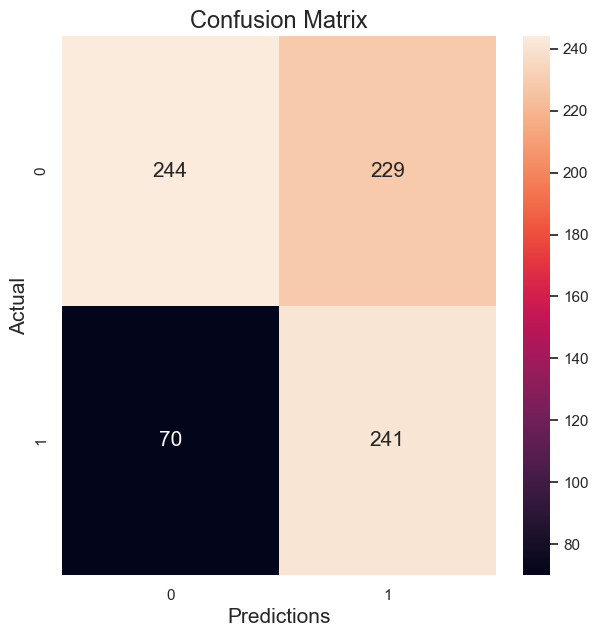

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# np.set_printoptions(precision=2, suppress=True)
import seaborn as sns
# plt.figure(figsize=(20,20))
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(confusion_matrix(test_labels_encoded, test_preds), annot=True, annot_kws={"size": 15}, fmt='g')
plt.ylabel('Actual',fontsize=15)
plt.xlabel('Predictions',fontsize=15)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

## Written Assignment (30 Points)

### 1. Describe what the task is, and how it could be useful.

The task here is to detect the presence of irony in tweets. The problem is a binary classification task with presence of irony as class 1 and absence as 0. The task can be useful when trying to analyse sentiments realated to a topic on social media. The presence of irony can often change the meaning from a seemingly positive sentiment to a negative one. If a model fails to detect this aspect, the results of the analysis can be misleading. Adding a irony detection model to the pipeline can help add more information and the analysis can be made while being aware of this aspect being present in the model. A sentiment classification model may overlook this detail as it may not be trained on a dataset with many instances of such irony. There trining a model explicitly to detect irony can be very useful to understand the direction in which the sentiments are pointing.

### 2. Describe, at the high level, that is, without mathematical rigor, how pretrained word embeddings like the ones we relied on here are computed. Your description can discuss the Word2Vec class of algorithms, GloVe, or a similar method.

The pretrained word embeddings, whether they come from word2vec of GloVe, fundamentally try to represent the meanings of words in low dimensional vectors (50-500 dimensions). These vectors have relative distances that can explain words occurring in similar contect and the relative directions correspond to meanings that make common sense. In short they create a vector space where similar words appear close to each other and moving in any particular direction changes the meanings of words that correspond a uniform aspect in the meaning (positive/negative for example). 

The pretrained embeddings in case of word2vec are computed using a predictive model. We either try to predict the target word given a context, incase of CBOW, or predict the context given a target word, in case of skip-gram method. While making this prediction, the models use trainable weights that produce a vector embeddings for every word and as the model gets better at making predictions, the embedings become better at encoding the relative meanings of words. 

In case of GLoVe, the embeddings are creating using a word co-occurrence matrix. Given a corpus, the word co-occurence matrix becomes a huge vocabulary x context matrix that counts how frequently a word appears in context of other words. This large matrix is then factorized to yeild a word x features matrix that contextualizes the menaing of words in the corpus into manageable ambeddings.

Both these methods yeild word embeddings that roughly do the same job of creating meaingful vectors that can represent relative the meanings of words and can provide various models a more usefule representation of words as compared to the sparse representation of words computed using word frequencies of TFIDF values.

### 3. What are some of the benefits of using word embeddings instead of e.g. a bag of words?

Bag of words can do a good job at contextualizing words, but these generally yeild very high-dimensional sparse vectors. Due to their nature, they can only capture high level information about the word based on the documents they appear in. When producing a vector representation for a document each word is represented by a position in the high dimensional matrix and if a word does not appear enough times in the corpus while trining for a specific task, the model does not know how to generalize to a new word given a new example. Embeddings solve this problem by creating low-dimensional dense representations of words that represent meanings in some vector space. Using such contexual embeddings, the model can understand a new word even if it hasnt appeared too often during training and therefore can lead to better performance across models.

### 4. What is the difference between Binary Cross Entropy loss and the negative log likelihood loss we used here (`torch.nn.NLLLoss`)?

We use the negative log lokelihood loss in here since we have the last layer in our model as the log softmax. The log softmax layer as opposed to the softmax layer computes the log of the probabilities for each class and therefore we cannot use the catgorical cross entropy loss that is typicallu used since this loss function also computes to log of probabilities while arriving at the loss. We, therefore, use the NLLLoss since this layer is aware that we already have the log probabilities computed and therefore just picks up the log probability corresponding the target label and negates it to compute the loss for that observation. This loss is then averaged over the batch to return the total loss for the batch and allow the model to backpropagate.

### 5. Show your experimental results. Indicate any changes to hyperparameters, data splits, or architectural changes you made, and how those effected results.

The main problem with the model based on my experiments was that the model overfit very easily. Especially when the the freeze parameter is set to FALSE, the trining loss quickly reduces to powers of -4 and -5 with trainng F1 at 1 even with dropouts set to large values like 0.7 or 0.8. The reason for this may be that there are about 6k words out of a total vocabulary of about 15k words that are not in the GLoVe embeddings. This means that about 40% of the words have randomly initialized embeddings. And since the train and test sets are relatovely small, there may not be a large overlap between the words in train set and words in test set. As a result a large proportion of the randomly initialized embeddings are never trained. This results in a significant number of embedding vectors that are just randomly initialied vectors from the OOV tokens in the test data. And as a result the model is not able to perform on the test data since these word embeddings make no sense and add noise to the input data.

One way to make this problem less severe would be to remove the OOV words appearing only in the test set from our vocabulary so that we do not initialize those tokens with random embeddings. This way we can route these unseen words to the <UNK> token which can represent them better than randomly initialized weights. Also to train the <UNK> token we may have to randomly selct a few tokens from the training set and delete them from the vocabulary, otherwise the model may never come across the <UNK> token while training. 

I found during my expriments (summarized in the table below), that opening up the embedding layer to be trainable results in severe overfitting as probably there is very little overlapping tokens in the training and testing set. I also found that using 200d embeddings causes too much overfitting as the training F1 quickly reached 1 with testing F1 struggling to cross the benchmark naive bayes performance. But one of the best results in my experiments was also using 200d embeddings with F1 score on test set at 0.6538. But this model is severely overfit. The result using the 100d embeddings and single RNN layer with the embedding layer frozen are very close at 0.6527 and the model is not severely overfit with training F1 at 0.8861. This model is the one I would choose for runnung inferences if needed as I would expect this one to generalize better.

I also found that since the models overfit severely, reducing the layers in the LSTM led to lower f1 on train set but improved performance in the test set. Since the challenge here is not that the model is not able to learn but that the data in train and test set is too disjoint, reducing the size of the model in this way helped to achieve better test performance.

I also tried to change the bidirectional LSTM to uni-directional to reduce some overfitting, but this resulted in poor performance across the board, so I have not included those results. I also tried a lot of models with the embeddings layer unfrozen, but the performance was below the benchmark in most cases, so I have only included a select few examples to show that the model performs poorly. I found that a single layer bi-directional LSTM with close to 16 hidden units, a learning rate or 0.001 and no dropouts resulted in consistent performace at f1 score of about 0.64 to 0.65 on test set.

![Irony Detection results](irony_detection_results.png)